## Notebook 6 : Selection de Device

<u>Objectif</u> : Le but de se notebook est de réaliser une étude sur les devices afin d'améliorer la prédiction de nos modèles.

Ce notebook présente quatre approches : 
* Retirer les devices immobiles
* Retirer les messages ayant été captés par des bases très lointaines 
* Combiner les deux premières approches
* Variation de la deuxième approche en utilisant un seuil de distance maximal

Ce notebook démontre que les deux premières approches ne donnent pas des résultats très fructueux.  

In [15]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
from IotTools import *
from sklearn.ensemble import RandomForestRegressor

In [17]:
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')
listOfBs = np.union1d(df_mess_train.bsid.unique(),df_mess_test.bsid.unique())

In [18]:
#On crée la liste des messages avec leur coordonées
pos_train['messid'] = df_mess_train.messid
msg_coord = pos_train.groupby('messid').mean()
msg_coord.head(1)

,lat,lng
messid,,
573bf1d9864fce1a9af8c5c9,39.60669,-104.95849


In [19]:
#On corrige les bases
X_train= Correct_Bases(df_mess_train)

Nous avons 27 bases outliers


In [20]:
#On produit la feature des distances
X_train['dist']=0
for i in X_train.index:
    base_coord = (X_train.iloc[i].bs_lat,X_train.iloc[i].bs_lng)
    mess_coord = (msg_coord.loc[X_train.iloc[i].messid].lat,msg_coord.loc[X_train.iloc[i].messid].lng)
    X_train.loc[i,'dist']=vincenty(base_coord,mess_coord)
X_train.head(1)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,dist
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,1.270478


In [21]:
# Ajout des coordonnées du message dans les features
X_train = pd.merge(X_train,msg_coord,on='messid')
X_train.head(1)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,dist,lat,lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,1.270478,39.60669,-104.95849


# Prédiction de référence
Avant de rétirer des devices, nous allons faire une première prédiction pour utiliser son score comme référence  
L'objectif, par la suite, est d'améliorer ce score en retirant des devices problématiques.

In [22]:
df_feat, id_list=feat_mat_const(X_train, listOfBs)
y_full = ground_truth_const(X_train, pos_train[['lat','lng']], id_list)
y_full.shape,df_feat.shape

((6068, 3), (6068, 273))

In [36]:
clf=RandomForestRegressor()
y_pred_lng_Etr = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
y_pred_lat_Etr = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_Etr, y_pred_lng_Etr)
np.percentile(err_vec, 80)

3.333165

Le **score de référence** est **3.33** en utilisant un modèle RandomForestRegressor.

# Prédiction sans les devices
Une étude réalisé dans le notebook 5 a permis de cibler 9 devices difficiles à prédire.  
Ces devices ont été retirés de l'entrainement puis une prédiction a été réalisée en utilisant le même modèle que le point de référence.

In [24]:
a=[476598,476896,476256,476513,476889,476248,473288,476327,476836]
X_mod = X_train[~X_train.did.isin(a)]
df_feat, id_list=feat_mat_const(X_mod, listOfBs)
y_full = ground_truth_const(X_mod, pos_train[['lat','lng']], id_list)
y_full.shape,df_feat.shape

((4876, 3), (4876, 273))

In [27]:
clf=RandomForestRegressor()
y_pred_lng_Etr = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
y_pred_lat_Etr = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_Etr, y_pred_lng_Etr)
np.percentile(err_vec, 80)

2.612264

En retirant neuf devices, le nouveau score est **2.61** s'améliore considérablement.  

# Idée 1 : les devices immobiles entrain un poids dans l'entrainement
La première idée considérée est de supprimer les devices qui sont immobiles. Cette étude va permettre d'observer le poids d'un device qui est capté plusieurs fois par une base sans bouger.

In [37]:
# Les bases ne contenant aucun message où les device n'ont pas bougé
X_train_mob=X_train.drop_duplicates(subset=['bsid','lat','lng'])
X_train_mob.shape

(39062, 14)

In [ ]:
#tous les messages où le devices n'a pas bougé (il en reste 1 dans l'autre base)
device_stop = X_train[~X_train.index.isin(X_train_mob.index)]
device_stop.shape

(188, 14)

In [ ]:
df_feat, id_list=feat_mat_const(X_train_mob, listOfBs)
y_full = ground_truth_const(X_train_mob, pos_train[['lat','lng']], id_list)
y_full.shape,df_feat.shape

((6030, 3), (6030, 273))

In [ ]:
clf=RandomForestRegressor()
y_pred_lng_Etr = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
y_pred_lat_Etr = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_Etr, y_pred_lng_Etr)
np.percentile(err_vec, 80)

3.1694637999999995

Le score passe à **3.169** ce qui est une amélioration. Toutefois, cette amélioration n'est pas significative.  
Donc retirer ces données de l'entrainement n'est pas forcément une bonne idée.

# Idée 2 : Suppression des messages captés par des bases lointaines
Une autre intuition a été de supprimer les messages qui ont été anormalement reçus par des bases étant très loin des devices emetteurs.

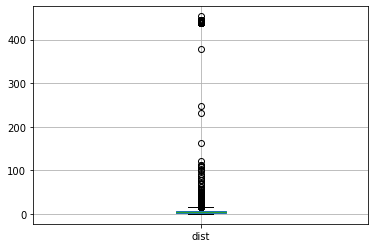

In [39]:
## Présence importante d'outliers concernant la distance device - base
X_train[['dist']].boxplot();

In [ ]:
#Tous les messages étant capté à moins de 200 Km
X_train_dist=X_train[X_train.dist<200]
X_train_dist.shape

(39070, 14)

In [ ]:
msg_too_long = X_train[~X_train.index.isin(X_train_dist.index)]
msg_too_long.shape

(180, 14)

In [ ]:
df_feat, id_list=feat_mat_const(X_train_dist, listOfBs)
y_full = ground_truth_const(X_train_dist, pos_train[['lat','lng']], id_list)
y_full.shape,df_feat.shape

((6020, 3), (6020, 273))

In [ ]:
clf=RandomForestRegressor()
y_pred_lng_Etr = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
y_pred_lat_Etr = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_Etr, y_pred_lng_Etr)
np.percentile(err_vec, 80)

3.20801

Encore une fois, le score baisse (**3.2**) mais, comme pour la première intuition, elle ne justifie pas la suppression de ces messages du dataset.

# Combinons les 2 idées 
Les deux hypothèses ayant des résultants peu concluants, il a été décidé de combiner les deux approches.

In [ ]:
X_train_mob=X_train.drop_duplicates(subset=['bsid','lat','lng'])
X_train_dist=X_train_mob[X_train_mob.dist<200]
X_train.shape[0]-X_train_mob.shape[0],X_train_mob.shape[0]-X_train_dist.shape[0]

(188, 34)

In [ ]:
df_feat, id_list=feat_mat_const(X_train_dist, listOfBs)
y_full = ground_truth_const(X_train_dist, pos_train[['lat','lng']], id_list)
y_full.shape,df_feat.shape

((6017, 3), (6017, 273))

In [ ]:
clf=RandomForestRegressor()
y_pred_lng_Etr = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
y_pred_lat_Etr = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_Etr, y_pred_lng_Etr)
np.percentile(err_vec, 80)

3.2260444

Cette proposition est pire que les deux premières car elle donne de moins bons résultats.

# Conclusion
Ainsi à l'aide de nos recherches, il est possible de conclure que les devices statiques et les messages captés à longue distance n'impactent pas les performances de prédiction.

### Dernière intuition : Utilisation d'un seuil pour la distance maximale
A l'aide du boxplot tracé ci-dessus, on observe qu'un nombre très important de messages captés avec une distance *device-base* dépassant largement 30 km.
En fixant un seuil d'environ 40Km, on obtient des résultats très encourageants (environ **2.6**)

### Seuil à 45Km, Score : 2.61
En utilisant un seuil à 45 km (c'est-à-dire supprimer les messages dont la distance est supérieure à 45km), on observe une amélioration considérable du score (**2.61**) 

In [ ]:
#On retire les 3271 messages qui ont été capté de trop loin
did_out = X_train[X_train.dist>45].did.unique()
len(did_out),X_train[X_train.did.isin(did_out)].shape

(11, (9616, 14))

In [ ]:
X_mod = X_train[~X_train.did.isin(did_out)]
df_feat, id_list=feat_mat_const(X_mod, listOfBs)
y_full = ground_truth_const(X_mod, pos_train[['lat','lng']], id_list)
y_full.shape,df_feat.shape

((4294, 3), (4294, 273))

In [ ]:
y_pred_lng_Etr = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
y_pred_lat_Etr = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_Etr, y_pred_lng_Etr)
np.percentile(err_vec, 80)

2.6150558000000004

### Seuil à 40Km, Score : 2.60


In [ ]:
did_out = X_train[X_train.dist>40].did.unique()
len(did_out),X_train[X_train.did.isin(did_out)].shape

(14, (14283, 14))

In [ ]:
X_mod = X_train[~X_train.did.isin(did_out)]
df_feat, id_list=feat_mat_const(X_mod, listOfBs)
y_full = ground_truth_const(X_mod, pos_train[['lat','lng']], id_list)
y_full.shape,df_feat.shape

((4122, 3), (4122, 273))

In [ ]:
y_pred_lng_Etr = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
y_pred_lat_Etr = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_Etr, y_pred_lng_Etr)
np.percentile(err_vec, 80)

2.6047738000000003

### Seuil à 35Km, Score : 2.61

In [ ]:
did_out = X_train[X_train.dist>35].did.unique()
len(did_out),X_train[X_train.did.isin(did_out)].shape

(15, (14673, 14))

In [ ]:
X_mod = X_train[~X_train.did.isin(did_out)]
df_feat, id_list=feat_mat_const(X_mod, listOfBs)
y_full = ground_truth_const(X_mod, pos_train[['lat','lng']], id_list)
y_full.shape,df_feat.shape

((4066, 3), (4066, 273))

In [ ]:
df_feat, id_list=feat_mat_const(X_mod, listOfBs)
y_full = ground_truth_const(X_mod, pos_train[['lat','lng']], id_list)
clf=RandomForestRegressor()
y_pred_lng_Etr = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
y_pred_lat_Etr = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_Etr, y_pred_lng_Etr)
np.percentile(err_vec, 80)

2.613954